In [113]:
import re
import os
import gzip
import time
import matplotlib.pyplot as plt
directory = "Practice_02_data/"


In [114]:
#### Cell of all my function

def list_file_data(nom_directory):
    myListFile = []
    for f in os.listdir(nom_directory):
        if os.path.isdir(f): # si f est un dossier
            os.chdir(f) # On va lister son contenu
            parse()
            os.chdir('../') # On revient au répertoire précédent
        else:
            myListFile.append(f)
        # Traitement sur le fichier f
    return myListFile


def preprocesDataFile(fileName):
    input_file = gzip.open(fileName, 'rb')
    full_text = input_file.read()
    docListNum = re.findall('<doc><docno>(.*?)</docno>(.*?)</doc>', str(full_text).lower().strip())
    list_doc = re.findall('<doc><docno>(.*?)</docno>', str(full_text).strip())
    return docListNum, list_doc

def countWord(words):   
    word_count = {} # compte l'occurance d'un terme dans tous les documents
    for word in words: # On nparcours la listes de mots*
        word  = word.lower()
        if not word in word_count:
            word_count[word] = 1
        else:
            word_count[word] = word_count[word] + 1
    return word_count

def countWordIntoDocs(dico, docno, posting):
    docname = docno
    
    for word, frequence in dico.items():
        posting.setdefault(word,[]).append((docname,frequence)) ### Remplace les lignes de commande suivante:
        """
        if not word in list(posting.keys()):
            posting[word] = [(docname, frequence)]
        else:
            posting[word].append((docname, frequence))
        """
    return posting

def document_lenght(list_terms,posting_list):
    dl = {}
    for doc, value in list_terms.items():
        somme_tf = 0
        for term in value:
            for val in sorted(posting_list[term]):
                if val[0]==doc:
                    somme_tf+=val[1]
        dl[doc]=somme_tf
        return dl
    
def vocabulary_size(posting_list):
    return len(posting_list.keys())

def collection_term_freq(posting_list):
    c_size={}
    for k,v in posting_list.items():
        somme=0
        for _,f in v: 
            somme+=f
        dl[k]=somme

In [115]:
### Cell to initialise variable
list_data = list_file_data(directory)
posting_list = {}
posting_list_global = {}
file_indexing_infos = {}
tf = {}
x_axis = list()
y_time = list()
list_terms = {}

In [116]:
for index in range(len(list_data)):
    start = time.time()
    list_terms.clear()
    posting_list.clear()
    fileName = str(directory+list_data[index])#'01-Text_Only-Ascii-Coll-1-10-NoSem.gz'
    docListNum, list_doc = preprocesDataFile(fileName)
    size = os.path.getsize(fileName)

    for i in range(len(list_doc)):
        list_terms[list_doc[i]] = docListNum[i][1].replace('\\n', '').split() # Here we create a dictionary of 
                                                                              # each docments with its terms
        lt = docListNum[i][1].replace('\\n', '').split()
        current_dico = countWord(lt)
        posting_list = countWordIntoDocs(current_dico, list_doc[i], posting_list)

    file_number = fileName.replace('Practice_02_data/','').split('-',1)
    for k,v in posting_list.items():
        vocub_size+=len(posting_list[k])
    end = time.time()
    elapsed = end - start
    tf[file_number[0]] = [(i, len(i)) for i in posting_list.keys()]
    dl[file_number[0]] = document_lenght(list_terms, ) 
    file_indexing_infos[file_number[0]]=(round(elapsed,3),tf[file_number[0]].values())
    

In [117]:
#print(list_doc)
for key, values in file_indexing_infos.items():
    x_axis.append(key)
    y_time.append(values[0])
    

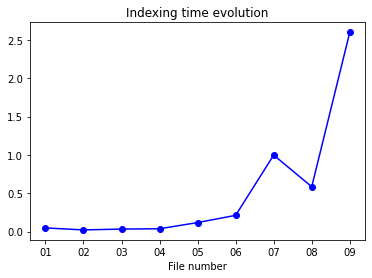

In [118]:
## Pour avoir une courbe avec le plot
plt.plot(x_axis,y_time, color='blue',marker='o',linestyle='solid')

#Titre
plt.title("Indexing time evolution")

# label
plt.xlabel("File number")
plt.show()